In [1]:
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon
from l5kit_conflict.pickle.io import load_potential_conflict_pickle, report_AVHV_conflicts, report_HVHV_conflicts
from l5kit_conflict.filter.helper import multiline_to_single_line, multi2singleLineString
from l5kit_conflict.analysis.conflict import Conflict
from l5kit_conflict.analysis.trajectory import Trajectory
from l5kit_conflict.analysis.post_process import post_process, compute_position_based_velocities, three_sigma_smoothing

np.set_printoptions(suppress=True)
plt.style.use("ggplot")

D:\github\lyft_intersection\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [3]:
# %% load datasets.
delta_time = 10  # 10 seconds for now [April 3rd, meeting];
AVHV_val_conflict_dataset = load_potential_conflict_pickle(dataset_type="AVHV", dataset_name="validate",
                                                           delta_time=delta_time)
HVHV_val_conflict_dataset = load_potential_conflict_pickle(dataset_type="HVHV", dataset_name="validate",
                                                           delta_time=delta_time)

AVHV_train_conflict_dataset = load_potential_conflict_pickle(dataset_type="AVHV", dataset_name="train2",
                                                             delta_time=delta_time)
HVHV_train_conflict_dataset = load_potential_conflict_pickle(dataset_type="HVHV", dataset_name="train2",
                                                             delta_time=delta_time)

print("Post-processing")
conflicts = []
conflicts = conflicts + post_process(AVHV_val_conflict_dataset, "val")
conflicts = conflicts + post_process(AVHV_train_conflict_dataset, "train")
# 646 AVHV/HVAV conflicts

Post-processing


In [ ]:
# %% define the collections of TAs.
HVHV_TAs = []
AVHV_TAs = []
HVAV_TAs = []
HVHV_TAs_merge = []
AVHV_TAs_merge = []
HVAV_TAs_merge = []
HVHV_TAs_cross = []
AVHV_TAs_cross = []
HVAV_TAs_cross = []

plt.figure(figsize=(4,3))

print("Calculate the TA distribution")
for index, conflict in enumerate(conflicts):
    print(index)
    first_xyt = np.hstack(
        [conflict.first_trajectory.xy, conflict.first_trajectory.t.reshape((-1,1))])
    second_xyt = np.hstack(
        [conflict.second_trajectory.xy, conflict.second_trajectory.t.reshape((-1,1))])
    
    # extract the trajectory within the study rectangle
    first_xyt = first_xyt[
        (first_xyt[:, 0] <= Trajectory.X_MAX) &
        (first_xyt[:, 0] >= Trajectory.X_MIN) &
        (first_xyt[:, 1] <= Trajectory.Y_MAX) &
        (first_xyt[:, 1] >= Trajectory.Y_MIN)
    ]
    second_xyt = second_xyt[
        (second_xyt[:, 0] <= Trajectory.X_MAX) &
        (second_xyt[:, 0] >= Trajectory.X_MIN) &
        (second_xyt[:, 1] <= Trajectory.Y_MAX) &
        (second_xyt[:, 1] >= Trajectory.Y_MIN)
    ]
    
    # take the first timestamp that two vehicles co-exist
    coexist_start_time = max(first_xyt[0, 2], second_xyt[0, 2])
    first_xyt = first_xyt[
        (conflict.first_time_at_conflict > first_xyt[:, 2]) &
        (first_xyt[:, 2] >= coexist_start_time)
        ]    
    second_xyt = second_xyt[
        (conflict.first_time_at_conflict > second_xyt[:, 2]) &
        (second_xyt[:, 2] >= coexist_start_time)
        ]
    
    # %% discard the samples with short trajectory (unable to calculate position-based speed)
    if first_xyt.shape[0] < 3 or second_xyt.shape[0] < 3:
        continue
    assert first_xyt[0, 2] == second_xyt[0, 2], \
        f"Two vehicles' initial states were not in the same time instant."
    
    
    if first_xyt.shape[0] !=  second_xyt.shape[0]:
        print("Non-equal two trajectories", first_xyt.shape, second_xyt.shape)
        len_traj = min(first_xyt.shape[0], second_xyt.shape[0]) - 2
    else:
        len_traj = first_xyt.shape[0] - 2

    this_traj_TAs = []
    for jdx in range(len_traj):
        # %% calculate the length and speed -> to get TA
        len_first_traj = LineString(first_xyt[jdx:, :2]).length  
        vs = compute_position_based_velocities(first_xyt[jdx:, :2])
        # print(vs.shape)
        first_speeds = three_sigma_smoothing(vs)
        print(first_speeds.shape)
        first_speed = first_speeds[3]
        len_second_traj = LineString(second_xyt[jdx:, :2]).length
        second_speed = three_sigma_smoothing(compute_position_based_velocities(second_xyt[jdx:, :2]))[3]
        TA = len_second_traj / second_speed - len_first_traj / first_speed
       
        if conflict.is_first_AV:
            AVHV_TAs.append(TA)
            if conflict.category == "merge":
                AVHV_TAs_merge.append(TA)
            else:
                AVHV_TAs_cross.append(TA)
        else:
            HVAV_TAs.append(TA)
            if conflict.category == "merge":
                HVAV_TAs_merge.append(TA)
            else:
                HVAV_TAs_cross.append(TA)
        this_traj_TAs.append(TA)

        
    # # print(conflict.is_first_AV, conflict.PET)
    # # conflict.plot()

    # if index == 55:
    #     plt.plot(this_traj_TAs)
    #     # print(this_traj_TAs)
    #     # plt.scatter(first_xyt[:len(this_traj_TAs),0], first_xyt[:len(this_traj_TAs),1], c=this_traj_TAs, s=2, vmin=-10, vmax=10)
    #     # plt.scatter(second_xyt[:len(this_traj_TAs),0], second_xyt[:len(this_traj_TAs),1], c=this_traj_TAs, s=2, vmin=-10, vmax=10)
    #     # plt.colorbar()
    #     # plt.xlim((-800,-700))
    #     plt.ylim((-20,20))
    #     break
# plt.ylim([-50,50])

In [5]:
AVHV_TAs = np.array(AVHV_TAs)
HVAV_TAs = np.array(HVAV_TAs)
AVHV_TAs_merge = np.array(AVHV_TAs_merge)
HVAV_TAs_merge = np.array(HVAV_TAs_merge)
AVHV_TAs_cross = np.array(AVHV_TAs_cross)
HVAV_TAs_cross = np.array(HVAV_TAs_cross)

TA_MIN = -15
TA_MAX = 20

print(AVHV_TAs.shape)

AVHV_TAs = AVHV_TAs[
    (AVHV_TAs >= TA_MIN) &
    (AVHV_TAs <= TA_MAX)
]

print(AVHV_TAs.shape)

HVAV_TAs = HVAV_TAs[
    (HVAV_TAs >= TA_MIN) &
    (HVAV_TAs <= TA_MAX)
]

AVHV_TAs_merge = AVHV_TAs_merge[
    (AVHV_TAs_merge >= TA_MIN) &
    (AVHV_TAs_merge <= TA_MAX)
]
HVAV_TAs_merge = HVAV_TAs_merge[
    (HVAV_TAs_merge >= TA_MIN) &
    (HVAV_TAs_merge <= TA_MAX)
]

AVHV_TAs_cross = AVHV_TAs_cross[
    (AVHV_TAs_cross >= TA_MIN) &
    (AVHV_TAs_cross <= TA_MAX)
]
HVAV_TAs_cross = HVAV_TAs_cross[
    (HVAV_TAs_cross >= TA_MIN) &
    (HVAV_TAs_cross <= TA_MAX)
]

(19562,)
(14848,)


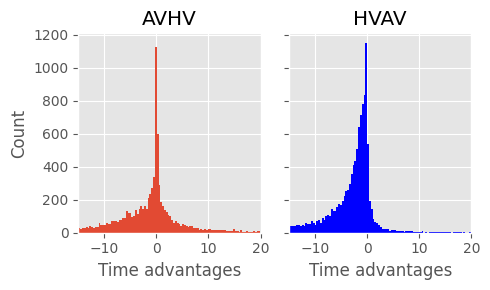

In [6]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs_merge, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs_merge, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()

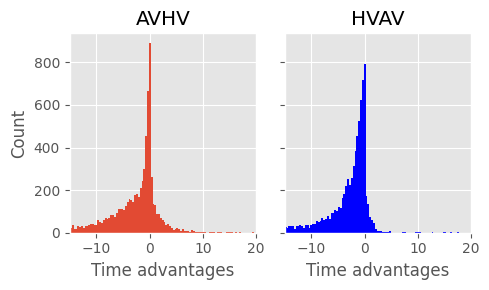

In [7]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs_cross, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs_cross, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()

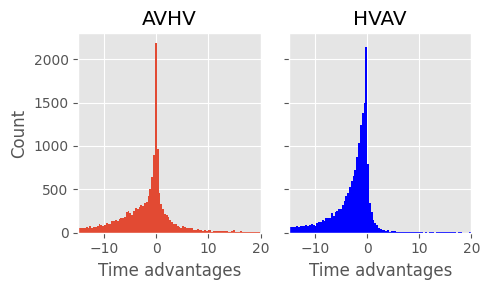

In [8]:
# %% draw distribution
fig, axs = plt.subplots(1, 2, figsize=(5, 3), sharey=True, sharex=True)

sca0 = axs[0].hist(x=AVHV_TAs, bins=100)
sca1 = axs[1].hist(x=HVAV_TAs, bins=100, color='blue')
# sca2 = axs[2].scatter(x=HVAV_PETs_cross, y=HVAV_average_speeds_first_cross, s=20, marker="o", c=HVAV_MRDs_cross, cmap="Reds", vmin=0, vmax=5)

axs[0].set_title(r"AVHV")
axs[0].set_xlabel("Time advantages")
axs[0].set_ylabel("Count")
axs[0].set_xlim([TA_MIN, TA_MAX])

axs[1].set_title(r"HVAV")
axs[1].set_xlabel("Time advantages")
# axs[1].set_ylabel("Average speed")

# axs[2].set_title(r"$\bf{HV}$-AV crossing")
# axs[2].set_xlabel("Post encroachment time")
# axs[2].set_ylabel("Average speed")

plt.tight_layout()
plt.show()